In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as op
from scipy import stats
import emcee
import corner
from scipy.stats import chisquare
from __future__ import division
%matplotlib inline

In [38]:
df=pd.read_csv("NED26.05.1-D-12.1.0-20160501.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[df['D (Mpc)']<500]
df=df[np.isfinite(df.err)]
df=df[df.err>0.]
#df=df[df['D (Mpc)']>35]

In [39]:
for i in np.unique(df.Method)[:-3]:
    df1=df[df.Method==i]
    print i,df1.shape


AGB (2, 15)
AGN time lag (31, 15)
B Stars (2, 15)
Black Hole (15, 15)
Blue Supergiant (2, 15)
Brightest Stars (128, 15)
CMD (1098, 15)
Carbon Stars (82, 15)
Cepheids (2249, 15)
D-Sigma (1119, 15)
Delta Scuti (12, 15)
Diameter (2, 15)
Dwarf Galaxy Diameter (10, 15)
Eclipsing Binary (252, 15)
FGLR (5, 15)
FP (11495, 15)
Faber-Jackson (1405, 15)
GC FP (3, 15)
GC SBF (3, 15)
GC dynamics (1, 15)
GC radius (101, 15)
GCLF (780, 15)
GeV TeV ratio (3, 15)
Grav. Stability Gas. Disk (2, 15)
H I + optical distribution (1, 15)
HII LF (1, 15)
HII region diameter (53, 15)
Horizontal Branch (94, 15)
IRAS (2945, 15)
LSB galaxies (1, 15)
M Stars (6, 15)
Magnitude (17, 15)
Maser (24, 15)
Mass Model (7, 15)
Miras (34, 15)
Novae (15, 15)
OB Stars (4, 15)
Orbital Mech. (3, 15)
PNLF (195, 15)
Proper Motion (4, 15)
RR Lyrae (416, 15)
RSV Stars (9, 15)
RV Stars (5, 15)
Red Clump (230, 15)
Ring Diameter (212, 15)
SBF (1907, 15)
SGRB (6, 15)
SNII optical (988, 15)
SNII radio (24, 15)
SNIa (2538, 15)
SX Phe Stars

In [40]:
np.unique(df1.Method)

array(['Tully-Fisher'], dtype=object)

In [41]:
# Select a method, here we choose Tully-Fisher (the last method selected in the previous cells)
listcut=np.unique(df1['Galaxy ID'])
listcut

array(['2MASX J00024069+0846251', '2MASX J00041398-5113247',
       '2MASX J00062236-5010027', ..., 'ZwCl 1115.2+3013 03',
       '[KKS2000] 30', '[RC3] 1234.6-1014'], dtype=object)

In [42]:
# reported distance error from error propagation of the reported distance modulus error for each measurement
disterr=0.461*df1['D (Mpc)']*df1.err 

In [206]:
%%time
errlist=np.zeros((len(listcut),7))
k=0
ncutoff=15
nbins=1 # resolution for the generated distributions
nreal=1000
for i in listcut:
    dfilter=(df1['Galaxy ID']==i)
    if(len(df1[dfilter])>ncutoff): # Select galaxies which have more than n measurements
        
        dummy=df1[dfilter]
        booterr=np.zeros(nreal)
        bootmean=np.zeros(nreal)
        for l in range(nreal):
            data=np.array([])
            for i in dummy.D:
                otherfilter=dummy.D==i
                # generate distance distribution for each distance modulus/ distance modulus error measurement
                AA=10**(np.random.normal(dummy['m-M'][otherfilter],dummy['err'][otherfilter],nbins)/5.+1)
                data=np.hstack((data,AA))            
            booterr[l]=np.percentile(data, 84)/1e6-np.percentile(data, 16)/1e6
            bootmean[l]=np.mean(data)
        dumerr=disterr[dfilter]
#        print np.mean(booterr),(np.percentile(booterr, 84)-np.percentile(booterr, 16)),dumerr.mean(),np.linalg.norm(dumerr/dummy['D (Mpc)'])*(dummy['D (Mpc)'].mean())

        em=len(df1[dfilter])
#        r = gmm.fit(data[:, np.newaxis])
        # Distances in Mpc
#        errlist[k,0]=r.means_[0, 0]/1e6 # Centroid of the GMM-fitted distribution
        errlist[k,0]=em # Number of measurements for each galaxy
#        errlist[k,2]=np.sqrt(r.covars_[0, 0])/1e6 # Variance of the GMM-fitted distribution
        errlist[k,1]=np.mean(booterr) # Percentiles of the combined distance distributions (50, 84, 16):
        errlist[k,2]=(np.percentile(booterr, 84)-np.percentile(booterr, 16))
        errlist[k,3]=dumerr.mean() # average reported error (Delta)
        errlist[k,4]=dummy['D (Mpc)'].mean() # average reported distance (D)
        errlist[k,5]=np.linalg.norm(dumerr/dummy['D (Mpc)'])*(dummy['D (Mpc)'].mean()) # rms error (D)
        errlist[k,6]=np.mean(bootmean)/1e6 # rms error (D)
    k+=1


CPU times: user 19min 50s, sys: 120 ms, total: 19min 51s
Wall time: 19min 52s


In [209]:
np.savetxt("errlist+20.csv", errlist, delimiter=",")

In [210]:
%%bash
git add bootstrap\ sampling.ipynb 
git commit -m "autocommit"
git push

Process is terminated.


In [118]:
np.savetxt("errlist+20+1000r.csv", errlist, delimiter=",")

In [211]:
(errlist[:,1]!=0).sum()

238

In [212]:
errlist

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

(0, 160)

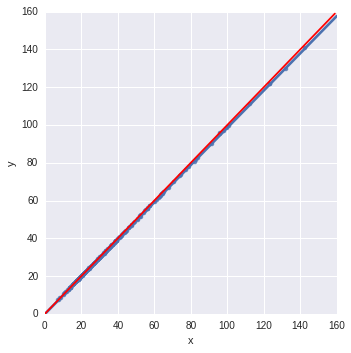

In [213]:
# mean vs. mean reported distance
x=errlist[(errlist[:,0]!=0)][:,6]
y=errlist[(errlist[:,0]!=0)][:,4]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
#plt.xlabel(r"$D_E$")
#plt.ylabel(r"$D (50\%)$")
aaa=160
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,aaa)

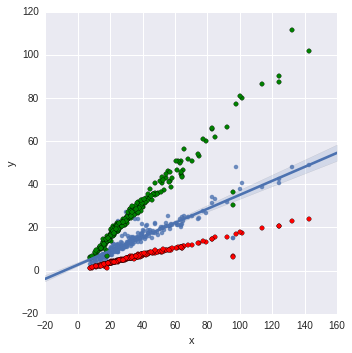

In [184]:
# mean dist vs. bootstrap error + mean reported error
x=errlist[(errlist[:,0]!=0)][:,6]
y=errlist[(errlist[:,0]!=0)][:,1]
z=errlist[(errlist[:,0]!=0)][:,3]
w=errlist[(errlist[:,0]!=0)][:,5]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
plt.scatter(x,z,c='r')
plt.scatter(x,w,c='g')

#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
#plt.xlabel(r"$D_E$")
#plt.ylabel(r"$D (50\%)$")

(0, 60)

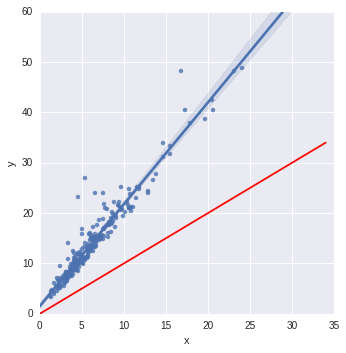

In [185]:
# mean vs. mean reported distance
x=errlist[(errlist[:,0]!=0)][:,3]
y=errlist[(errlist[:,0]!=0)][:,1]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
#plt.xlabel(r"$D_E$")
#plt.ylabel(r"$D (50\%)$")
aaa=35
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,60)

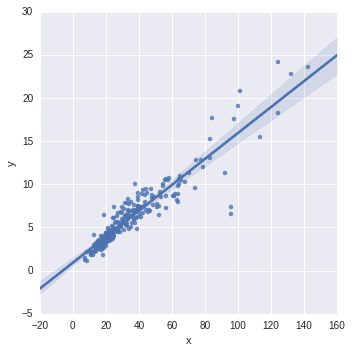

In [186]:
# distance vs. bootstrap error
x=errlist[(errlist[:,0]!=0)][:,6]
y=errlist[(errlist[:,0]!=0)][:,2]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
#plt.xlabel(r"$D_E$")
#plt.ylabel(r"$D (50\%)$")
aaa=60

In [214]:
x=errlist[(errlist[:,0]!=0)][:,6]
y=errlist[(errlist[:,0]!=0)][:,1]
yerr=errlist[(errlist[:,0]!=0)][:,2]

In [188]:
def lnlike(theta, x, y,yerr):
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/((yerr)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))


0.339696928378 1.48081420847


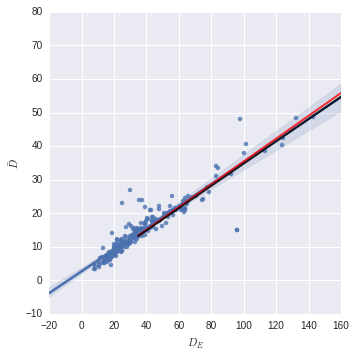

In [189]:
# gmm-fitted mean vs. unweighted mean
x=errlist[(errlist[:,0]!=0)][:,6]
y=errlist[(errlist[:,0]!=0)][:,1]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
# OLS fit
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(y * y)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
# ML fit
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y,yerr))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)
#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\bar{D}$")

#plt.ylim(0,aaa)

In [190]:
def lnprior(theta):
    m, b = theta
    if 0 < m < 1 and -5 < b < 8:
        return 0.0
    return -np.inf
def lnprob(theta, x, y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr)

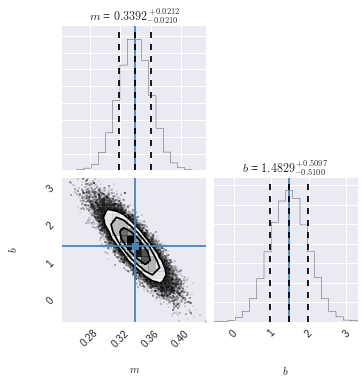

In [191]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [1, 1], args=(x, y,yerr))
m_ml, b_ml= result["x"]
ndim, nwalkers = 2, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y,yerr))
sampler.run_mcmc(pos, 1000);
samplesli = sampler.chain[:, 100:, :].reshape((-1, ndim))
meanestli=samplesli.mean(axis=0)
fig = corner.corner(samplesli, labels=["$m$", "$b$"],
                      truths=[meanestli[0], meanestli[1]], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

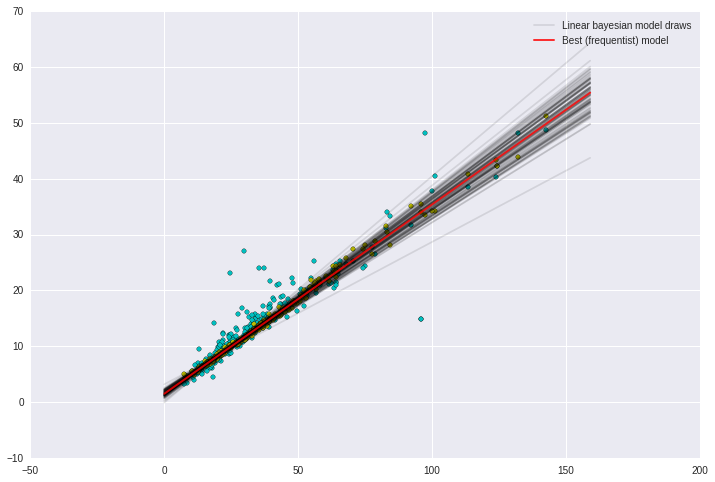

In [192]:
plt.figure(figsize=(12,8))
xl = np.arange(0,160)
for m, b in samplesli[np.random.randint(len(samplesli), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m*xl+b, color="k", alpha=0.1,label="Linear bayesian model draws")

plt.plot(xl, meanestli[0]*xl+meanestli[1], color="r", lw=2, alpha=0.8,label="Best (frequentist) model")
plt.scatter(x,y,c='c')
AAA=samplesli[np.random.randint(len(samplesli), size=len(x))]
yy_siml=AAA[:,0]*x+AAA[:,1]
plt.scatter(x,yy_siml,c='y')
plt.legend()

Bayesian p-value: 0.0
Rejection rate (%): 0.0


(0, 200)

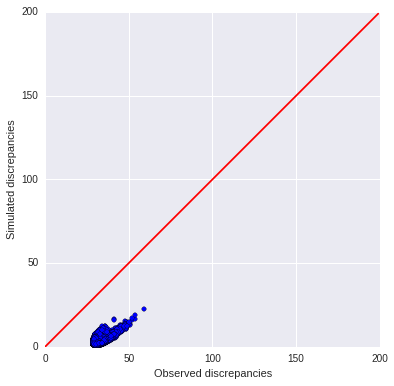

In [193]:
discobs=[]
discsim=[]
nrealiz=50000
for m,b in samplesli[np.random.randint(len(samplesli), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samplesli[np.random.randint(len(samplesli), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1] # create a synthetic dataset
    yexp=m*x+b # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim)
print "Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs)
# the model sometimes predicts negative values for errors, such datasets are rejected:
print "Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim) 
ppp=np.arange(200)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,200)
plt.ylim(0,200)

In [215]:
ydel=errlist[(errlist[:,0]!=0)][:,3] # mean error
#ydel=errlist[(errlist[:,0]!=0)][:,5] # rms error
ydel=yerr

In [195]:
# Likelihood
def lnlike(theta, x, y,yerr):
    m ,b,f = theta
    model = m * x +b+f*yerr # model equation
    inv_sigma2 = 1.0/((yerr)**2) # weighted by the GMM-fitted sigma
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2))) 
# Priors
def lnprior(theta):
    m, b,f = theta
    if -1 < m < 1 and -30 < b < 30 and -10 < f < 10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob(theta, x, y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr)

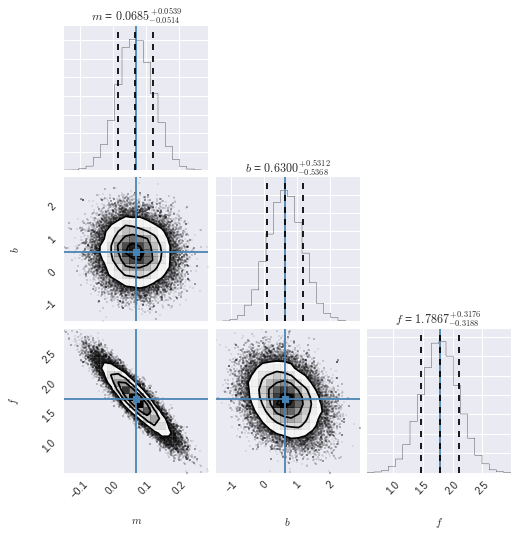

In [196]:
# This block uses the emcee MCMC sampler to estimate the posterior probability
# 1. Guess the starting places for the walkers from a maximum likelihood fit
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [1,1,1], args=(x, y,yerr))
m_ml, b_ml,f_ml= result["x"]
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y,yerr)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],
                      truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

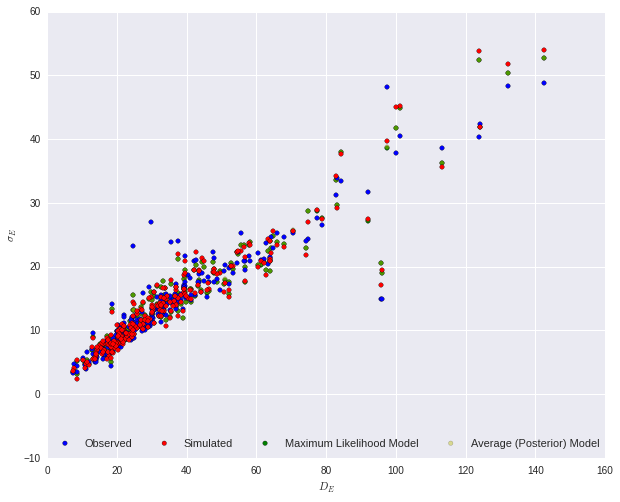

In [197]:
plt.figure(figsize=(10,8))

AAA=samples[np.random.randint(len(samples), size=len(x))]
y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr
y_ml=m_ml*x+b_ml+f_ml*yerr
y_me=meanest[0]*x+meanest[1]+meanest[2]*yerr
plml = plt.scatter(x,y_ml,c='g')
plme = plt.scatter(x,y_me,c='y',alpha=0.4)
plobs = plt.scatter(x,y)
plsim = plt.scatter(x,y_sim,c='r')
#plt.scatter(x,w,c='k')
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\sigma_E$")
plt.legend((plobs, plsim, plml, plme),
           ('Observed', 'Simulated', 'Maximum Likelihood Model', 'Average (Posterior) Model'),
           scatterpoints=1,
           loc='lower center',
           ncol=4,
           fontsize=11)

plt.show()

Meta-chisq-statistic: 759.567446304 DOF: 20000
Meta p-value (should be low): 0.0


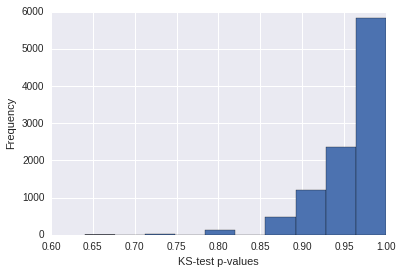

In [198]:
listaksst=[]
listakspv=[]
rvs1 = (y)
ndsets=10000 # number of tests to run
for i in range(ndsets):
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr
    rvs3 = (y_sim)
    listaksst.append(stats.ks_2samp(rvs1, rvs3)[0])
    listakspv.append(stats.ks_2samp(rvs1, rvs3)[1]) # here are the p values
listaksst=np.asarray(listaksst)
listakspv=np.asarray(listakspv)
cpval=-2*(np.log(listakspv)).sum() # Fisher's method statistic
print "Meta-chisq-statistic:", cpval, "DOF:",2*ndsets
print "Meta p-value (should be low):", stats.chi2.cdf(cpval, 2*ndsets)
plt.hist(listakspv)
plt.xlabel("KS-test p-values")
plt.ylabel("Frequency")

Bayesian p-value: 0.0
Rejection rate (%): 0.0


(0, 200)

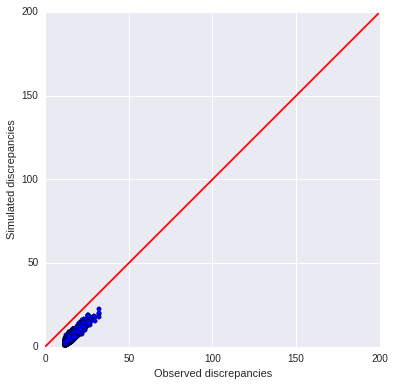

In [199]:
discobs=[]
discsim=[]
nrealiz=50000
for m,b,f in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr # create a synthetic dataset
    yexp=m*x+b+f*yerr # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim)
print "Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs)
# the model sometimes predicts negative values for errors, such datasets are rejected:
print "Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim) 
ppp=np.arange(200)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,200)
plt.ylim(0,200)

In [216]:
ydel=errlist[(errlist[:,0]!=0)][:,3] # mean error
ydel=errlist[(errlist[:,0]!=0)][:,5] # rms error
ydel=yerr

In [217]:
# Likelihood
def lnlike(theta, x, y,yerr,ydel):
    m ,b,n,f,o,g = theta
    model = m * x +b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # model equation
    inv_sigma2 = 1.0/((yerr)**2) # weighted by the GMM-fitted sigma
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2))) 
# Priors
def lnprior(theta):
    m, b,n,f,o,g = theta
    if -2 < m < 2 and -20 < b < 20 and  -1 < n < 1 and -10 < f < 10 and -10 < o < 10 and -10 < g < 10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob(theta, x, y,yerr,ydel):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr,ydel)

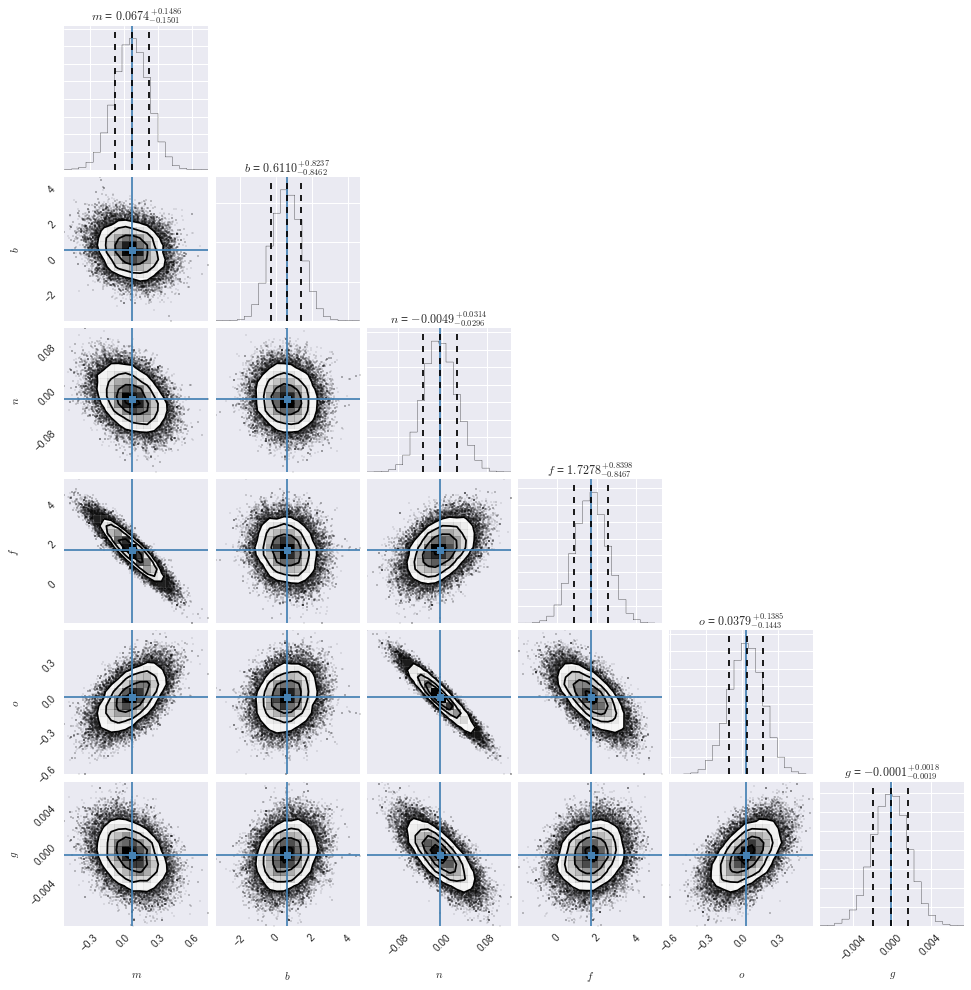

In [218]:
# This block uses the emcee MCMC sampler to estimate the posterior probability
# 1. Guess the starting places for the walkers from a maximum likelihood fit
nll = lambda *args: -lnlike(*args)
argum=(x, y,yerr,ydel)
result = op.minimize(nll, [1,1,1,1,1,1], args=argum)
m_ml, b_ml,n_ml,f_ml,o_ml,g_ml= result["x"]
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=argum) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$n$","$f$","$o$","$g$"],
                      truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

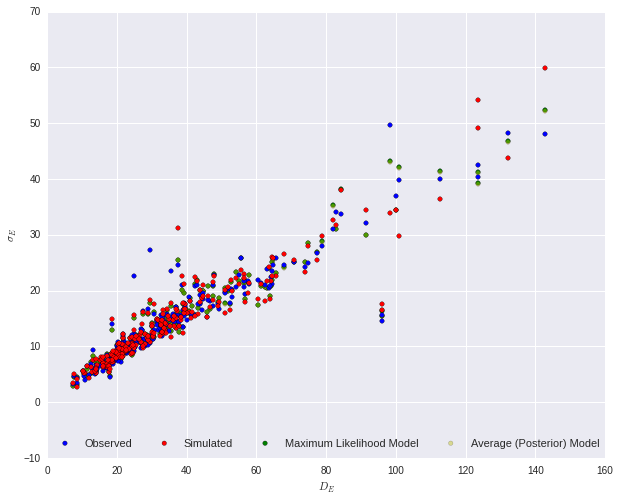

In [219]:
plt.figure(figsize=(10,8))

AAA=samples[np.random.randint(len(samples), size=len(x))]
y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2
y_ml=m_ml*x+b_ml+n_ml*ydel*x+f_ml*ydel+o_ml*ydel**2+g_ml*x**2
y_me=meanest[0]*x+meanest[1]+meanest[2]*ydel*x+meanest[3]*ydel+meanest[4]*ydel**2+meanest[5]*x**2
plml = plt.scatter(x,y_ml,c='g')
plme = plt.scatter(x,y_me,c='y',alpha=0.4)
plobs = plt.scatter(x,y)
plsim = plt.scatter(x,y_sim,c='r')
#plt.scatter(x,w,c='k')
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\sigma_E$")
plt.legend((plobs, plsim, plml, plme),
           ('Observed', 'Simulated', 'Maximum Likelihood Model', 'Average (Posterior) Model'),
           scatterpoints=1,
           loc='lower center',
           ncol=4,
           fontsize=11)

plt.show()

Meta-chisq-statistic: 816.021921624 DOF: 20000
Meta p-value (should be low): 0.0


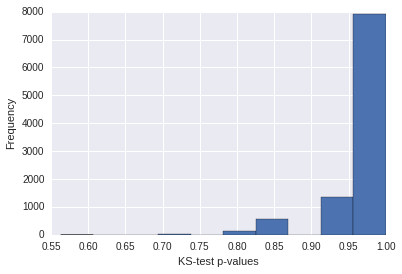

In [204]:
listaksst=[]
listakspv=[]
rvs1 = (y)
ndsets=10000 # number of tests to run
for i in range(ndsets):
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2
    rvs3 = (y_sim)
    listaksst.append(stats.ks_2samp(rvs1, rvs3)[0])
    listakspv.append(stats.ks_2samp(rvs1, rvs3)[1]) # here are the p values
listaksst=np.asarray(listaksst)
listakspv=np.asarray(listakspv)
cpval=-2*(np.log(listakspv)).sum() # Fisher's method statistic
print "Meta-chisq-statistic:", cpval, "DOF:",2*ndsets
print "Meta p-value (should be low):", stats.chi2.cdf(cpval, 2*ndsets)
plt.hist(listakspv)
plt.xlabel("KS-test p-values")
plt.ylabel("Frequency")

Bayesian p-value: 0.18014
Rejection rate (%): 0.116


(0, 200)

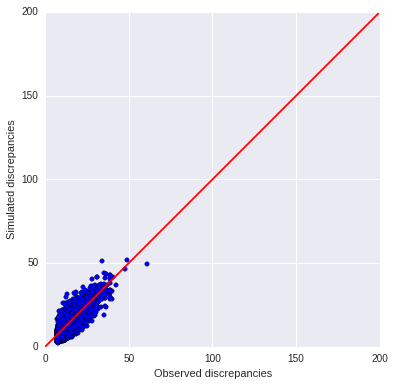

In [220]:
discobs=[]
discsim=[]
nrealiz=50000
for m,b,n,f,o,g in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2 # create a synthetic dataset
    yexp=m*x+b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim)
print "Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs)
# the model sometimes predicts negative values for errors, such datasets are rejected:
print "Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim) 
ppp=np.arange(200)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,200)
plt.ylim(0,200)